In [ ]:
!pip uninstall --yes qiskit qiskit-terra

In [ ]:
!pip install qiskit

In [ ]:
!pip install -U qiskit-aer

## A Quantum Peg

In [112]:
from qiskit.compiler import transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# This is the first simple version
# Number of qubits representing the path/position
num_qubits = 4 
qc = QuantumCircuit(num_qubits, num_qubits)

# Initialize the "ball" (e.g., in a specific starting position)
qc.x(0) # Invert the first qubit for a specific starting condition
# Here we simulate the "pegs" using controlled operations and superposition
qc.h(0) # Introduce superposition for a "peg"
# Simulate interaction and path change (i.e. swap left for input 2)
qc.cswap(0, 1, 2) 
# add control 1 if the ball fell
qc.cx(2,0)
# Add more layers of "pegs" as needed for the desired depth of the QGB
qc.cswap(0, 2, 3)
# Measure the final state
qc.measure(range(num_qubits), range(num_qubits))

## For more than 2, we need to Reset: qubit initialize zero..somehow

# Run the circuit on a simulator
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(compiled_circuit)

print("Measurement results:", counts)

Measurement results: {'0001': 522, '0000': 502}


In [113]:
qc.draw()

┌───┐┌───┐   ┌───┐      ┌─┐      
q_0: ┤ X ├┤ H ├─■─┤ X ├────■─┤M├──────
     └───┘└───┘ │ └─┬─┘┌─┐ │ └╥┘      
q_1: ───────────X───┼──┤M├─┼──╫───────
                │   │  └╥┘ │  ║ ┌─┐   
q_2: ───────────X───■───╫──X──╫─┤M├───
                        ║  │  ║ └╥┘┌─┐
q_3: ───────────────────╫──X──╫──╫─┤M├
                        ║     ║  ║ └╥┘
c: 4/═══════════════════╩═════╩══╩══╩═
                        1     0  2  3

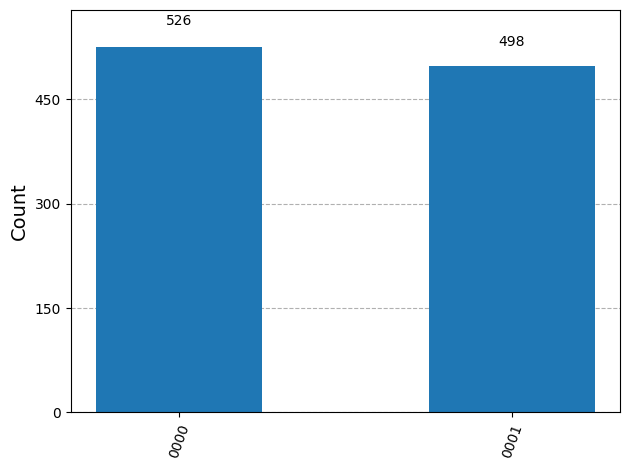

In [114]:
## Plot distribution
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [115]:
from qiskit_aer import Aer

## 3 Pegs, 2-levels (Binomial Distribution)

Measurement Counts: {'10': 258, '00': 249, '01': 517}


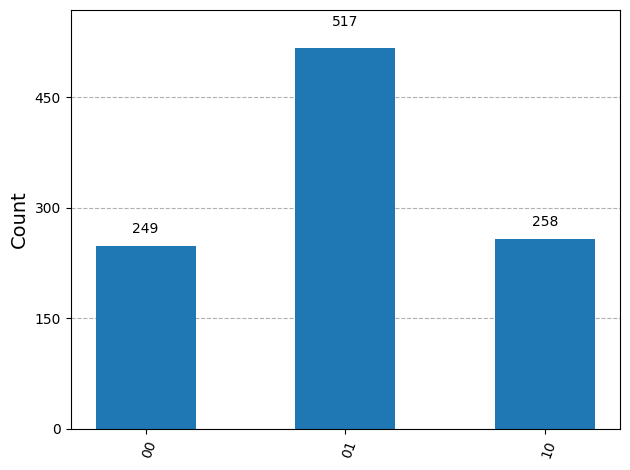

In [116]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Number of levels (rows of pegs) in the Galton box
num_levels = 2

# Number of qubits required (num_levels for position + 1 for ancilla)
num_qubits = num_levels + 1

# Create a quantum circuit with 3 qubits and 2 classical bits
qc1 = QuantumCircuit(num_qubits, num_levels)

# Initialize the first qubit (representing the ball's initial position) to a superposition
# Using a Hadamard gate on the first qubit simulates the 50/50 chance of going left or right
qc1.h(0) 

# Apply a Hadamard gate to the second qubit for the next level
qc1.h(1)

# Level 1 (first peg row)
qc1.cswap(0, 1, 2)  # Control: qubit 0 (previous position), Targets: qubits 1 and 2 (next positions)

# Level 2 (second peg row)
qc1.cswap(1, 0, 2)  # Control: qubit 1 (previous position), Targets: qubits 0 and 2 (next positions)

# Measure the first two qubits to determine the final position
qc1.measure([0, 1], [0, 1]) 
simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator
compiled_circuit = transpile(qc1, simulator)

# Execute the circuit and get the results
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()

# Get the measurement outcomes
counts = result.get_counts(qc1)
print("Measurement Counts:", counts)

# Plot the results as a histogram
plot_histogram(counts)


In [117]:
compiled_circuit.draw()

┌───┐      ┌─┐   
q_0: ┤ H ├─■──X─┤M├───
     ├───┤ │  │ └╥┘┌─┐
q_1: ┤ H ├─X──■──╫─┤M├
     └───┘ │  │  ║ └╥┘
q_2: ──────X──X──╫──╫─
                 ║  ║ 
c: 2/════════════╩══╩═
                 0  1

**Notes:** If you use the above method, the circuit becomes too noisy.
- Tried to implement a version where the swap looks at the level before
- to implement a reset, and this was too noisy.

## N Pegs, n-level-Board

In [168]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

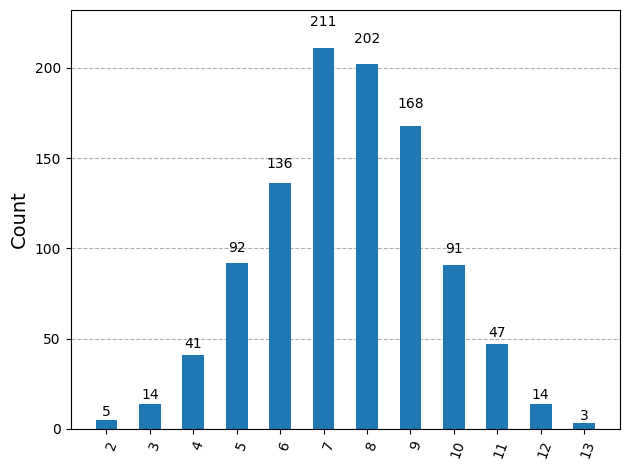

In [174]:
# set number of levels and pegs
n_levels_and_pegs = 8

# we need the ClassicalRegister for our swap
qr = QuantumRegister(n, 'q')
cr = ClassicalRegister(n, 'c')
qc3 = QuantumCircuit(qr, cr)

# We use the usual hadamard to simulate our pegs, but this time,
# we use a loop to initialize the levels and pegs
# for a simple n-level board, Hadamard gates suffice to generate the binomial distribution.
for i in range(n_levels_and_pegs):
    qc3.h(qr[i])

# We take a measurement. 
qc3.measure(qr, cr)

## we measure after to get our distribution
# here we are counting in the bitstring the number of 1s
# this gives us a pretty good count of our distribution ie. binomial
bin_counts = {}
for bitstring, count in counts.items():
    num_ones = bitstring.count('1')
    bin_counts[num_ones] = bin_counts.get(num_ones, 0) + count

plot_histogram(bin_counts)

In [182]:
qc3.draw()

┌───┐   ┌─┐     
q_0: ┤ H ├─X─┤M├─|0>─
     ├───┤ │ └╥┘ ┌─┐ 
q_1: ┤ H ├─X──╫──┤M├─
     └───┘    ║  └╥┘ 
c: 2/═════════╩═══╩══
              0   1

- the basic Galton board can be simulated with independent Hadamard gates
Hadamard gates suffice to generate the binomial distribution.
Measure Results:
- After traversing all levels, measure each qubit and store the result in the classical register. 
- The sum of the measured bits (number of "rights" or "ones") will correspond to the final bin the ball lands in.

## Version using the swap gates and reset (very noisy!)

Measurement Counts: {'01': 241, '00': 275, '11': 244, '10': 264}


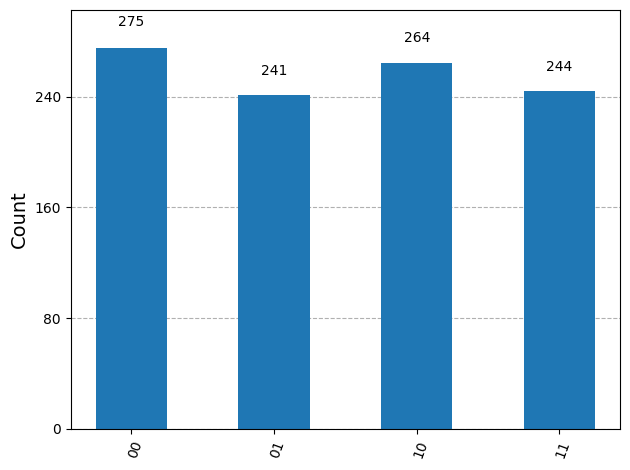

In [181]:
# Number of levels (rows of pegs) in the Galton box
num_levels = 8

# Number of qubits required (num_levels for position + 1 for ancilla)
num_qubits = 8

# Here we would create a quantum circuit with say, 3 qubits and 2 classical bits
# Instead, now, we have n_levels for the ball to traverse and we use 
# n_levels classical bits for measurements
qr = QuantumRegister(n_levels, 'q')
cr = ClassicalRegister(n_levels, 'c')
qc4 = QuantumCircuit(qr, cr)

# Initialize the first qubit (representing the ball's initial position) to a superposition
# Using a Hadamard gate on the first qubit simulates the 50/50 chance of going left or right
qc4.h(qr[0])


# We now put this in a for loop for multiple pegs at each level
for i in range(1, n_levels):
    # Simulate a peg: Hadamard for random left/right choice
    qc4.h(qr[i])
    
    # we use the SWAP here. Instead of a single swap i.e. qc1.cswap(0, 1, 2)
    # since we now have a for loop, we swap the previous level's choice
    # i.e. qr[i-1] to decide whether the current level qr[i] should swap
    # for the rhs bin
    # we then do a measure
    qc4.swap(qr[i-1], qr[i])

    # then we do a RESET. We need to measure before resetting or the histogram
    # only measures the last result i.e. 1 value
    qc4.measure(qr[i-1], cr[i-1])
    qc4.reset(qr[i-1])

qc4.measure(qr[n_levels -1], cr[n_levels - 1])

simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator
compiled_circuit = transpile(qc4, simulator)

# Execute the circuit and get the results
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()

# Get the measurement outcomes
counts = result.get_counts(qc4)
print("Measurement Counts:", counts)

# Plot the results as a histogram
plot_histogram(counts)

In [183]:
qc4.draw()

┌───┐   ┌─┐     
q_0: ┤ H ├─X─┤M├─|0>─
     ├───┤ │ └╥┘ ┌─┐ 
q_1: ┤ H ├─X──╫──┤M├─
     └───┘    ║  └╥┘ 
c: 2/═════════╩═══╩══
              0   1